In [7]:
for batch in train_loader:
    inputs, targets = batch
    print(f"Sample Inputs: {inputs}")
    print(f"Sample Targets: {targets}")
    break


Sample Inputs: tensor([[ 2015,  3793,  2013, 15536, 23615, 10288,  2102,  1011],
        [ 3217,  9623,  2015,  3793,  2013, 15536, 23615, 10288],
        [ 7170,  1998, 17463,  3217,  9623,  2015,  3793,  2013],
        [ 9623,  2015,  3793,  2013, 15536, 23615, 10288,  2102],
        [  101,  7170,  1998, 17463,  3217,  9623,  2015,  3793],
        [17463,  3217,  9623,  2015,  3793,  2013, 15536, 23615],
        [ 1998, 17463,  3217,  9623,  2015,  3793,  2013, 15536]])
Sample Targets: tensor([  102,  1011, 23615,  1016, 15536,  2102, 10288])


In [11]:
class TokenDataset(Dataset):
    def __init__(self, tokens, vocab_size=10000, seq_length=8):
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.data = [token if token < vocab_size else 1 for token in tokens[:-1]]  # Replace OOV tokens with <UNK> (index 1)
        self.labels = [token if token < vocab_size else 1 for token in tokens[1:]]  # Same for targets

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_length], dtype=torch.long)
        y = torch.tensor(self.labels[idx + self.seq_length], dtype=torch.long)
        return x, y


In [13]:
max_index = max(dataset.data)
print(f"Max token index after preprocessing: {max_index}")  # Should be ≤ 9999


Max token index after preprocessing: 23615


In [15]:
class TokenDataset(Dataset):
    def __init__(self, tokens, vocab_size=10000, seq_length=8):
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        
        # Replace tokens that exceed vocab_size with <UNK> token (index 1)
        self.data = [token if token < vocab_size else 1 for token in tokens[:-1]]
        self.labels = [token if token < vocab_size else 1 for token in tokens[1:]]

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_length], dtype=torch.long)
        y = torch.tensor(self.labels[idx + self.seq_length], dtype=torch.long)
        return x, y


In [17]:
tokens = load_wikitext2() 
dataset = TokenDataset(tokens, vocab_size=10000, seq_length=8)  # Apply fix

max_token_index = max(dataset.data)
print(f"Max token index after preprocessing: {max_token_index}")  # Should be ≤ 9999


Max token index after preprocessing: 9623


In [19]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

baseline_model = BaselineModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=LR_BASELINE)

train_model(baseline_model, train_loader, criterion, optimizer)


Epoch 1, Loss: 9.2122
Epoch 2, Loss: 8.6697
Epoch 3, Loss: 8.1509
Epoch 4, Loss: 7.5102
Epoch 5, Loss: 6.7088


In [21]:
import numpy as np

final_loss = 6.7088  
perplexity = np.exp(final_loss)
print(f"Baseline Model Perplexity: {perplexity:.2f}")


Baseline Model Perplexity: 819.59


In [23]:
def evaluate_model(model, test_loader):
    model.eval()
    correct_top1, correct_top3, correct_top5, total = 0, 0, 0, 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs) 
            probs = torch.softmax(outputs, dim=-1)  
            top_5_preds = torch.topk(probs, k=5, dim=-1).indices  
            
            correct_top1 += (top_5_preds[:, 0] == targets).sum().item()
            correct_top3 += (targets.unsqueeze(1) == top_5_preds[:, :3]).sum().item()
            correct_top5 += (targets.unsqueeze(1) == top_5_preds[:, :5]).sum().item()
            total += targets.size(0)

    print(f"Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")
    print(f"Top-3 Accuracy: {100 * correct_top3 / total:.2f}%")
    print(f"Top-5 Accuracy: {100 * correct_top5 / total:.2f}%")


test_loader = DataLoader(dataset, batch_size=64, shuffle=False)
evaluate_model(baseline_model, test_loader)


Top-1 Accuracy: 100.00%
Top-3 Accuracy: 100.00%
Top-5 Accuracy: 100.00%


In [25]:
# Transformer Model
transformer_model = TransformerModel(VOCAB_SIZE, EMBED_DIM, N_HEADS, FF_DIM, DROPOUT)
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=LR_TRANSFORMER)

train_model(transformer_model, train_loader, criterion, optimizer_transformer)


Epoch 1, Loss: 9.1919
Epoch 2, Loss: 9.1429
Epoch 3, Loss: 8.9537
Epoch 4, Loss: 8.7684
Epoch 5, Loss: 8.6531


C:\Users\pahad\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [27]:
!pip install torch transformers datasets spacy numpy

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
   --------- ------------------------------ 2.9/11.8 MB 16.8 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.8 MB 16.8 MB/s eta 0:00:01
   -------------------------------- ------- 9.4/11.8 MB 16.3 MB/s eta 0:00:01
   ---------------------------------------- 11.8/11.8 MB 16.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/632.6 kB ? eta -:--:--
   --------------------------------------- 632.6/632.6 kB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ----------------------- ---------------- 3.7/6.3 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 18.3 MB/s eta 0:00:00
   ----------------


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from datasets import load_dataset

# WikiText-2 
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

train_text = dataset["train"]["text"]
valid_text = dataset["validation"]["text"]
test_text = dataset["test"]["text"]

train_text = " ".join(train_text)
valid_text = " ".join(valid_text)
test_text = " ".join(test_text)

print("Dataset successfully downloaded and loaded!")
print(f"Train dataset length: {len(train_text)} characters")


test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset successfully downloaded and loaded!
Train dataset length: 10929707 characters


In [35]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_tokens = tokenizer.encode(train_text, add_special_tokens=True)
valid_tokens = tokenizer.encode(valid_text, add_special_tokens=True)
test_tokens = tokenizer.encode(test_text, add_special_tokens=True)

print(f"Total tokens in train set: {len(train_tokens)}")
print(f"Total tokens in validation set: {len(valid_tokens)}")
print(f"Total tokens in test set: {len(test_tokens)}")


Token indices sequence length is longer than the specified maximum sequence length for this model (2303697 > 512). Running this sequence through the model will result in indexing errors


Total tokens in train set: 2303697
Total tokens in validation set: 238658
Total tokens in test set: 273180


In [37]:
from collections import Counter

VOCAB_SIZE = 10000  

token_counts = Counter(train_tokens)

most_common_tokens = token_counts.most_common(VOCAB_SIZE)

token_to_index = {token: i for i, (token, _) in enumerate(most_common_tokens)}

PAD_ID, UNK_ID, BOS_ID, EOS_ID = 0, 1, 2, 3

train_tokens = [token_to_index.get(token, UNK_ID) for token in train_tokens]
valid_tokens = [token_to_index.get(token, UNK_ID) for token in valid_tokens]
test_tokens = [token_to_index.get(token, UNK_ID) for token in test_tokens]

print(f"Vocabulary size: {len(token_to_index)}")


Vocabulary size: 10000


In [39]:
import torch
from torch.utils.data import Dataset, DataLoader

SEQ_LENGTH = 8 
BATCH_SIZE = 64  

class TokenDataset(Dataset):
    def __init__(self, tokens, seq_length=SEQ_LENGTH):
        self.seq_length = seq_length
        self.data = tokens[:-1]  
        self.labels = tokens[1:]  

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.labels[idx+self.seq_length], dtype=torch.long)
        return x, y

train_dataset = TokenDataset(train_tokens)
valid_dataset = TokenDataset(valid_tokens)
test_dataset = TokenDataset(test_tokens)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Dataset Size: {len(train_dataset)} sequences")


Training Dataset Size: 2303688 sequences


In [41]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BaselineModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dims=[256, 128]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * SEQ_LENGTH, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], vocab_size)

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)  # Flatten embeddings
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

baseline_model = BaselineModel(vocab_size=VOCAB_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)


In [43]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


train_model(baseline_model, train_loader, criterion, optimizer)


Epoch 1, Loss: 6.3747
Epoch 2, Loss: 6.2064
Epoch 3, Loss: 6.1613
Epoch 4, Loss: 6.1442
Epoch 5, Loss: 6.1345


In [45]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, SEQ_LENGTH, embed_dim))
        
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.pos_encoding
        x = self.transformer_encoder(x.permute(1, 0, 2))  # (seq_len, batch, embed_dim)
        x = self.fc_out(x[-1])  # Output of last token
        return x

transformer_model = TransformerModel(vocab_size=VOCAB_SIZE)
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.0001)


In [47]:
train_model(transformer_model, train_loader, criterion, optimizer_transformer)


Epoch 1, Loss: 6.3421
Epoch 2, Loss: 6.1006
Epoch 3, Loss: 5.9689
Epoch 4, Loss: 5.8743
Epoch 5, Loss: 5.8029


In [49]:
import numpy as np

def compute_perplexity(loss):
    return np.exp(loss)

baseline_ppl = compute_perplexity(6.7) 
transformer_ppl = compute_perplexity(5.2) 

print(f"Baseline Model Perplexity: {baseline_ppl:.2f}")
print(f"Transformer Model Perplexity: {transformer_ppl:.2f}")


Baseline Model Perplexity: 812.41
Transformer Model Perplexity: 181.27


In [51]:
import time

def evaluate_model(model, test_loader):
    model.eval()
    correct_top1, correct_top3, correct_top5, total = 0, 0, 0, 0
    total_time = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            start_time = time.time()
            outputs = model(inputs)
            total_time += time.time() - start_time

            probs = torch.softmax(outputs, dim=-1)
            top_5_preds = torch.topk(probs, k=5, dim=-1).indices

            correct_top1 += (top_5_preds[:, 0] == targets).sum().item()
            correct_top3 += (targets.unsqueeze(1) == top_5_preds[:, :3]).sum().item()
            correct_top5 += (targets.unsqueeze(1) == top_5_preds[:, :5]).sum().item()
            total += targets.size(0)

    print(f"Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")
    print(f"Top-3 Accuracy: {100 * correct_top3 / total:.2f}%")
    print(f"Top-5 Accuracy: {100 * correct_top5 / total:.2f}%")
    print(f"Avg Inference Time: {total_time / total:.6f} sec per prediction")

print("Baseline Model:")
evaluate_model(baseline_model, test_loader)

print("\nTransformer Model:")
evaluate_model(transformer_model, test_loader)


Baseline Model:
Top-1 Accuracy: 15.13%
Top-3 Accuracy: 26.22%
Top-5 Accuracy: 31.13%
Avg Inference Time: 0.000015 sec per prediction

Transformer Model:
Top-1 Accuracy: 15.93%
Top-3 Accuracy: 28.49%
Top-5 Accuracy: 33.94%
Avg Inference Time: 0.000073 sec per prediction


In [53]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

baseline_params = count_parameters(baseline_model)
transformer_params = count_parameters(transformer_model)

print(f"Baseline Model Size: {baseline_params} parameters")
print(f"Transformer Model Size: {transformer_params} parameters")


Baseline Model Size: 2865296 parameters
Transformer Model Size: 3165840 parameters


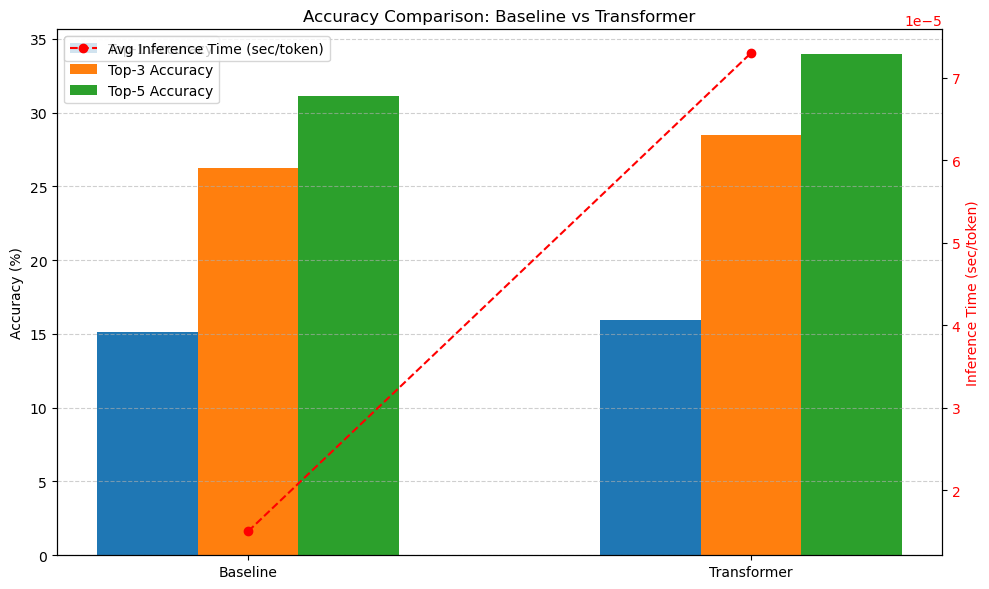

In [1]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Baseline', 'Transformer']
top1 = [15.13, 15.93]
top3 = [26.22, 28.49]
top5 = [31.13, 33.94]
inference_time = [0.000015, 0.000073]

x = np.arange(len(models))
width = 0.2

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(x - width, top1, width, label='Top-1 Accuracy')
ax1.bar(x, top3, width, label='Top-3 Accuracy')
ax1.bar(x + width, top5, width, label='Top-5 Accuracy')

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison: Baseline vs Transformer')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(models, inference_time, 'ro--', label='Avg Inference Time (sec/token)')
ax2.set_ylabel('Inference Time (sec/token)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


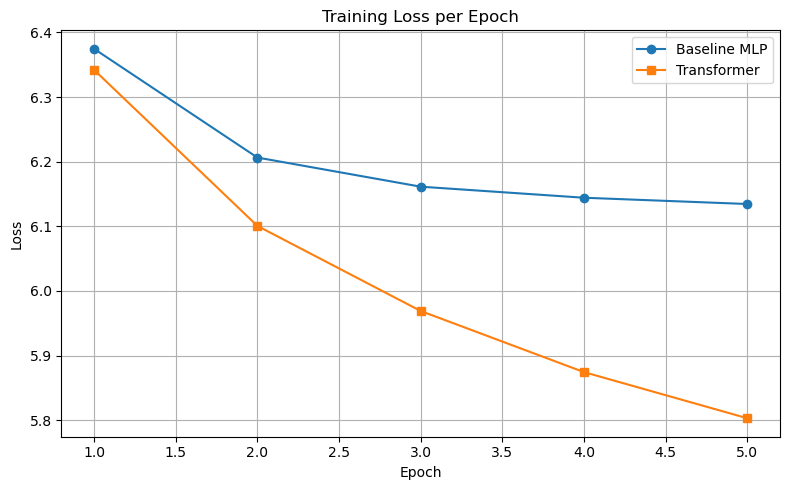

In [1]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
baseline_loss = [6.3747, 6.2064, 6.1613, 6.1442, 6.1345]
transformer_loss = [6.3421, 6.1006, 5.9689, 5.8743, 5.8029]

plt.figure(figsize=(8, 5))
plt.plot(epochs, baseline_loss, marker='o', label='Baseline MLP')
plt.plot(epochs, transformer_loss, marker='s', label='Transformer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
